In [247]:
import torchvision.models as models
model = models.vgg16(pretrained=True)

In [248]:
filename = './Berkeley.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


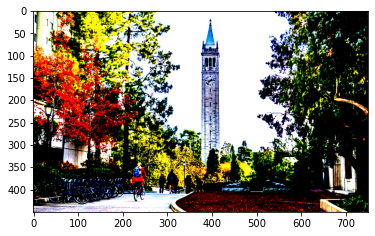

In [321]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

input_image = Image.open(filename)
preprocess = transforms.Compose([
#     transforms.Resize(256), 
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(input_image)
plt.imshow(input_tensor.permute(1, 2, 0))
plt.show()
input_batch = input_tensor.unsqueeze(0)
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)


In [279]:
def get_filter(model, l, n):
    """
    Obtains the nth filter at layer l of model.
    Output: Expect an tensor Nx3x3. 
    3x3 window with 3 channels, N being the input channel.
    """
    return list(model.parameters())[l][n]

print(get_filter(model, 4, 4).shape)

torch.Size([64, 3, 3])


In [347]:
def SELoss(x, y):
    """
    Takes in x and y as both tensors. 
    """
    return torch.sum(torch.square(x-y))

loss = SELoss

test1 = torch.tensor([[1, 1], [2, 2]], dtype=torch.float32, requires_grad=True)
test2 = torch.tensor([[0, 1], [0, 2]], dtype=torch.float32)

err = loss(test1, test2)
print(err)
err.backward()
print(test1.grad)

tensor(5., grad_fn=<SumBackward0>)
tensor([[2., 0.],
        [4., 0.]])


In [348]:
class FilterResponse:
    "Hook class for saving filter responses at layer x"
    
    def __init__(self):
        self.responses = []
        
    def __call__(self, module, module_in, module_out):
        self.responses.append(module_out)
    
    def clear(self):
        self.responses = []
        
    def __getitem__(self, idx):
        if type(idx) == tuple and len(idx) == 2:
            layer, i = idx
            return torch.squeeze(self.responses[layer])[i]
        elif type(idx) == int:
            return self.responses[idx]
        else:
            raise Exception('idx is either a tuple or a number.')
        
ground_truth = FilterResponse()
for layer in model.modules():
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        layer.register_forward_hook(ground_truth)


In [349]:
with torch.no_grad():
    output = model(input_batch)

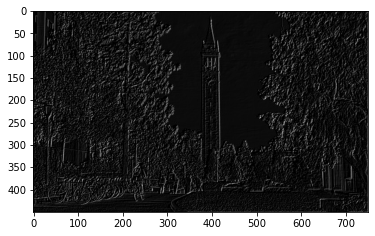

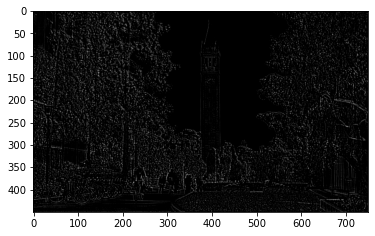

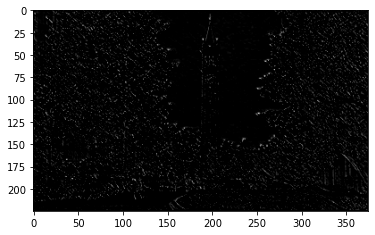

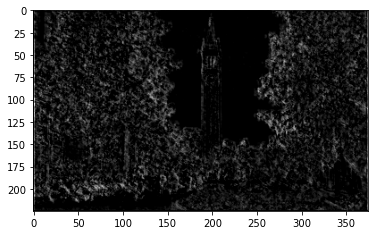

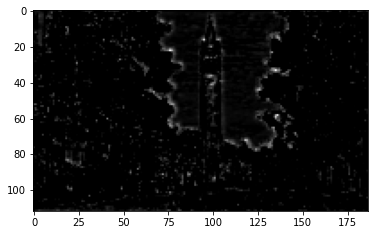

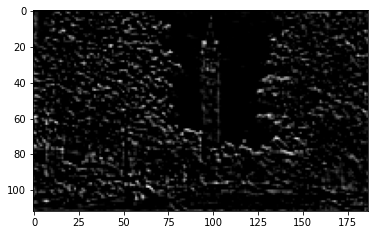

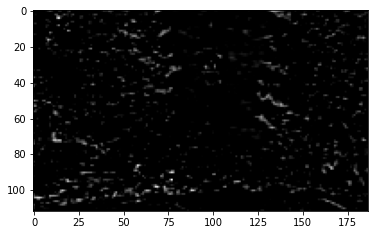

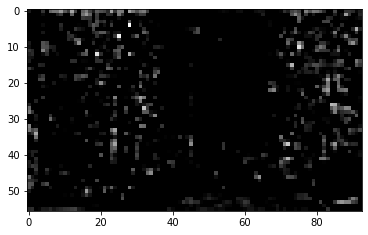

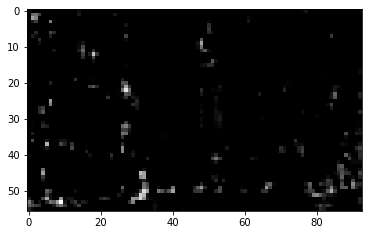

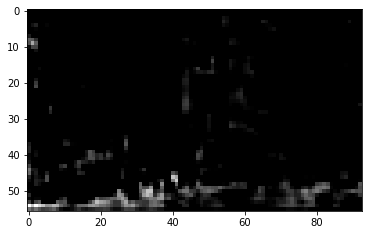

In [350]:
for i in range(0, 10):
    plt.imshow(ground_truth[i, 1], cmap='gray')
    plt.show()

In [351]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

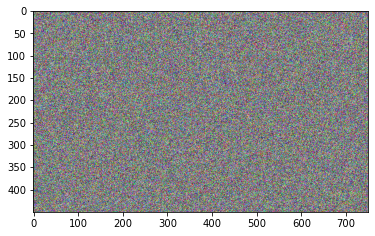

In [372]:
canvas = torch.rand(input_tensor.shape, dtype=torch.float32, requires_grad=True)

visualize_step(canvas)
prediction = FilterResponse()
training = models.vgg16(pretrained=True)
for layer in training.modules():
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        layer.register_forward_hook(prediction)


In [377]:
def visualize_step(canvas):
    canvas = canvas.detach().clone()
    canvas = inv_normalize(canvas)
#     for i in range(3):
#         canvas[i] -= canvas[i].min()
#         canvas[i] /= canvas[i].max()
    canvas = canvas.permute(1, 2, 0).numpy()
    plt.imshow(canvas)
    plt.show()
    return canvas

In [374]:
from torch.optim import SGD
l = 0
epochs = 100
lr = 0.01
optimizer = SGD([canvas], lr=lr)
for _ in range(epochs):
    optimizer.zero_grad()
    prediction.clear()
    out = training(canvas.unsqueeze(0))
    error = loss(prediction[l], ground_truth[l])
    print(error)
    error.backward()
    optimizer.step()
#     visualize_step(canvas)

tensor(1083924.6250, grad_fn=<SumBackward0>)
tensor(1012922.3750, grad_fn=<SumBackward0>)
tensor(954773.8750, grad_fn=<SumBackward0>)
tensor(906214.5000, grad_fn=<SumBackward0>)
tensor(865013.0625, grad_fn=<SumBackward0>)
tensor(829530.9375, grad_fn=<SumBackward0>)
tensor(798599.8125, grad_fn=<SumBackward0>)
tensor(771343.1250, grad_fn=<SumBackward0>)
tensor(747088.5000, grad_fn=<SumBackward0>)
tensor(725295.3125, grad_fn=<SumBackward0>)
tensor(705551.5000, grad_fn=<SumBackward0>)
tensor(687541.2500, grad_fn=<SumBackward0>)
tensor(670978., grad_fn=<SumBackward0>)
tensor(655638.2500, grad_fn=<SumBackward0>)
tensor(641354.1250, grad_fn=<SumBackward0>)
tensor(627975.1250, grad_fn=<SumBackward0>)
tensor(615372.6875, grad_fn=<SumBackward0>)
tensor(603447.4375, grad_fn=<SumBackward0>)
tensor(592115.5000, grad_fn=<SumBackward0>)
tensor(581296.9375, grad_fn=<SumBackward0>)
tensor(570947.3750, grad_fn=<SumBackward0>)
tensor(560991.2500, grad_fn=<SumBackward0>)
tensor(551375.6250, grad_fn=<SumBa

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


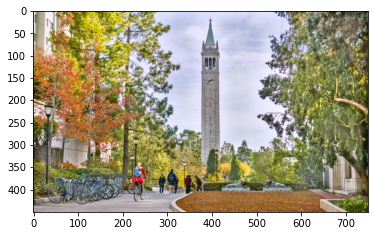

Lossy conversion from float32 to uint8. Range [-0.1108958050608635, 1.2290937900543213]. Convert image to uint8 prior to saving to suppress this warning.


In [378]:
import skimage.io as skio
skio.imsave('0th-layer.jpg', visualize_step(canvas))